In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import os

from PIL import Image
import io
import base64

import random
from shapely.geometry import Polygon


In [57]:
TEST_FILE = "/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/labels/0809_1058.json"

In [58]:
from shapely.geometry import Polygon

def order_points_convex(points):
    """
    Orders the points to form a convex quadrilateral (rectangle).
    """
    if len(points) != 4:
        return points  # Only works for quadrilaterals
    
    # Calculate the centroid of the points
    centroid_x = sum(p[0] for p in points) / 4
    centroid_y = sum(p[1] for p in points) / 4
    
    # Sort points by angle relative to the centroid
    def angle_from_centroid(point):
        return math.atan2(point[1] - centroid_y, point[0] - centroid_x)
    
    sorted_points = sorted(points, key=angle_from_centroid)
    return sorted_points

In [59]:
def filter_images_with_4_plus_keypoints(directory):
    """
    Filters images that have polygons with more than 4 keypoints.
    Returns a list of file paths for such images.
    """
    json_files = [f for f in os.listdir(directory) if f.endswith(".json")]
    filtered_files = []

    for filename in json_files:
        json_path = os.path.join(directory, filename)
        with open(json_path, 'r') as f:
            keypoints = json.load(f)
        
        if "shapes" not in keypoints:
            continue
        
        for shape in keypoints["shapes"]:
            if len(shape["points"]) > 4:
                filtered_files.append(json_path)
                break  # Stop checking other shapes in the same file
    
    return filtered_files

In [60]:
def is_convex(points):
    """
    Checks if the given points form a convex polygon.
    """
    if len(points) < 3:
        return False  # A polygon must have at least 3 points
    
    polygon = Polygon(points)
    return polygon.is_valid and polygon.convex_hull.equals(polygon)

In [61]:
def ensure_rectangle_shape(points):
    """
    Ensures the points form a rectangle-shaped polygon.
    """
    if len(points) != 4:
        return points  # Only works for quadrilaterals
    
    # Order the points to form a convex quadrilateral
    ordered_points = order_points_convex(points)
    
    # Check if the ordered points form a convex polygon
    if is_convex(ordered_points):
        return ordered_points
    else:
        # If not convex, adjust the points slightly
        adjusted_points = [(x + 0.01 * i, y + 0.01 * i) for i, (x, y) in enumerate(ordered_points)]
        return adjusted_points

In [62]:
import math

def find_closest_points(points):
    min_distance = float('inf')
    closest_pair = None
    
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if distance < min_distance:
                min_distance = distance
                closest_pair = (i, j)
    
    return closest_pair

In [63]:
def replace_closest_points(points):
    if len(points) > 4:
        # Find the two closest points
        i, j = find_closest_points(points)
        # Calculate the midpoint of the two closest points
        midpoint = (
            (points[i][0] + points[j][0]) / 2,
            (points[i][1] + points[j][1]) / 2
        )
        # Replace the two closest points with the midpoint
        new_points = [point for idx, point in enumerate(points) if idx not in (i, j)]
        new_points.append(midpoint)
        return new_points
    return points

In [64]:
def reorder_points(points):
    """
    Reorders the points to ensure:
    - x1: top-left
    - x2: top-right
    - x3: bottom-right
    - x4: bottom-left
    """
    if len(points) != 4:
        return points  # Only works for quadrilaterals
    
    # Sort points by y-coordinate (top to bottom)
    sorted_by_y = sorted(points, key=lambda p: p[1])
    
    # Separate top and bottom points
    top_points = sorted_by_y[:2]  # Top two points (smallest y)
    bottom_points = sorted_by_y[2:]  # Bottom two points (largest y)
    
    # Sort top points by x-coordinate (left to right)
    top_points_sorted = sorted(top_points, key=lambda p: p[0])
    x1 = top_points_sorted[0]  # Top-left
    x2 = top_points_sorted[1]  # Top-right
    
    # Sort bottom points by x-coordinate (left to right)
    bottom_points_sorted = sorted(bottom_points, key=lambda p: p[0])
    x4 = bottom_points_sorted[0]  # Bottom-left
    x3 = bottom_points_sorted[1]  # Bottom-right
    
    # Return reordered points
    return [x1, x2, x3, x4]

In [65]:
def compare_original_and_replacement(filename):
    with open(filename, 'r') as f:
        keypoints = json.load(f)
    detections = keypoints["shapes"]
    image = Image.open(filename.replace("json", "jpg").replace("labels", "images"))
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot original polygon
    axes[0].imshow(image)
    axes[0].set_title("Original Polygon")
    for points in detections:
        # Reorder points to ensure the top-left point is first
        reordered_points = reorder_points(points["points"])
        x_coords, y_coords = zip(*reordered_points)
        axes[0].plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), marker='o', linestyle='-', label=points["label"])
        axes[0].fill(x_coords, y_coords, alpha=0.3)
        # Highlight extra keypoints
        if len(reordered_points) > 4:
            extra_x, extra_y = zip(*reordered_points[4:])
            axes[0].scatter(extra_x, extra_y, color='red', s=100, label='Extra Keypoints')
        axes[0].legend()
    
    # Plot replacement polygon
    axes[1].imshow(image)
    axes[1].set_title("Replacement Polygon")
    for points in detections:
        handled_points = replace_closest_points(points["points"])
        # Ensure polygon validity
        handled_points = ensure_rectangle_shape(handled_points)
        # Reorder points to ensure the top-left point is first
        reordered_handled_points = reorder_points(handled_points)
        x_coords, y_coords = zip(*reordered_handled_points)
        axes[1].plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), marker='o', linestyle='-', label=points["label"])
        axes[1].fill(x_coords, y_coords, alpha=0.3)
        # Highlight the replacement point
        if len(points["points"]) > 4:
            replacement_x, replacement_y = reordered_handled_points[-1]
            axes[1].scatter(replacement_x, replacement_y, color='green', s=100, label='Replacement Point')
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()

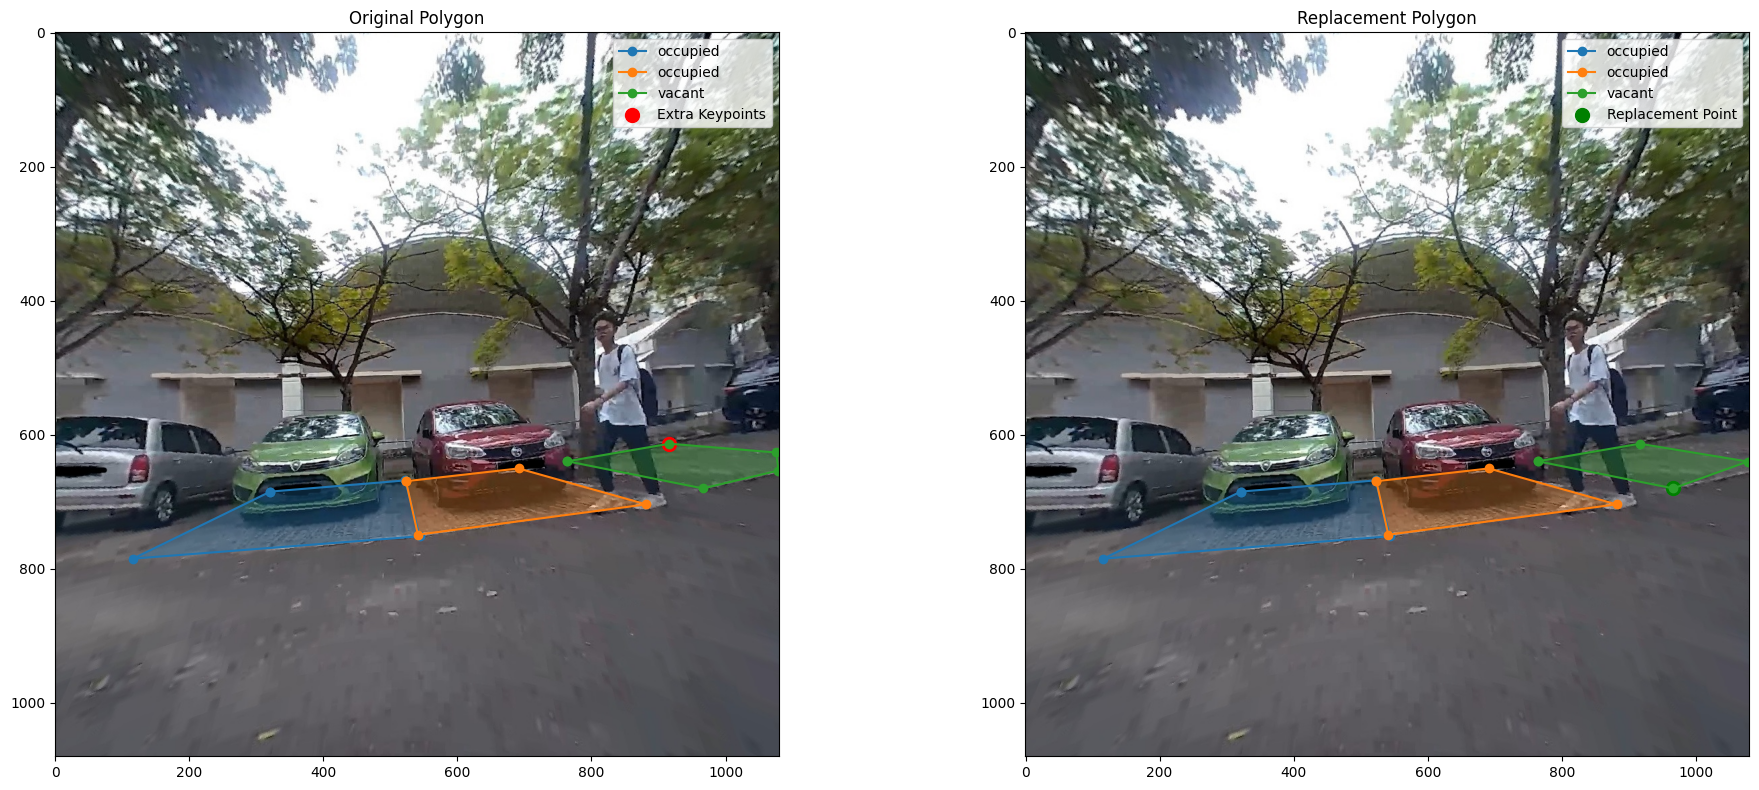

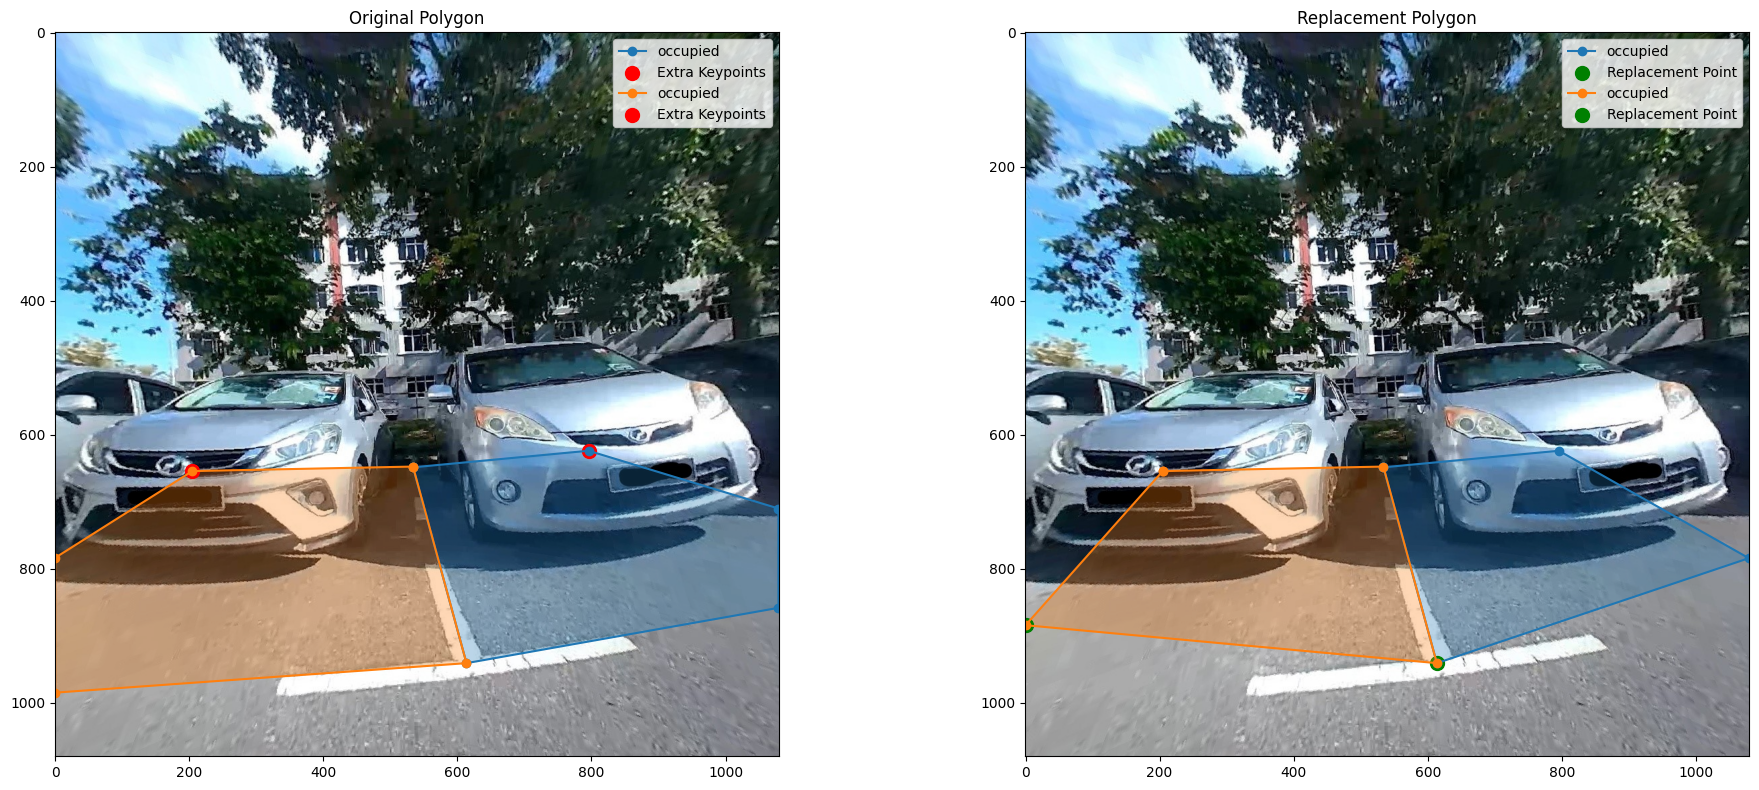

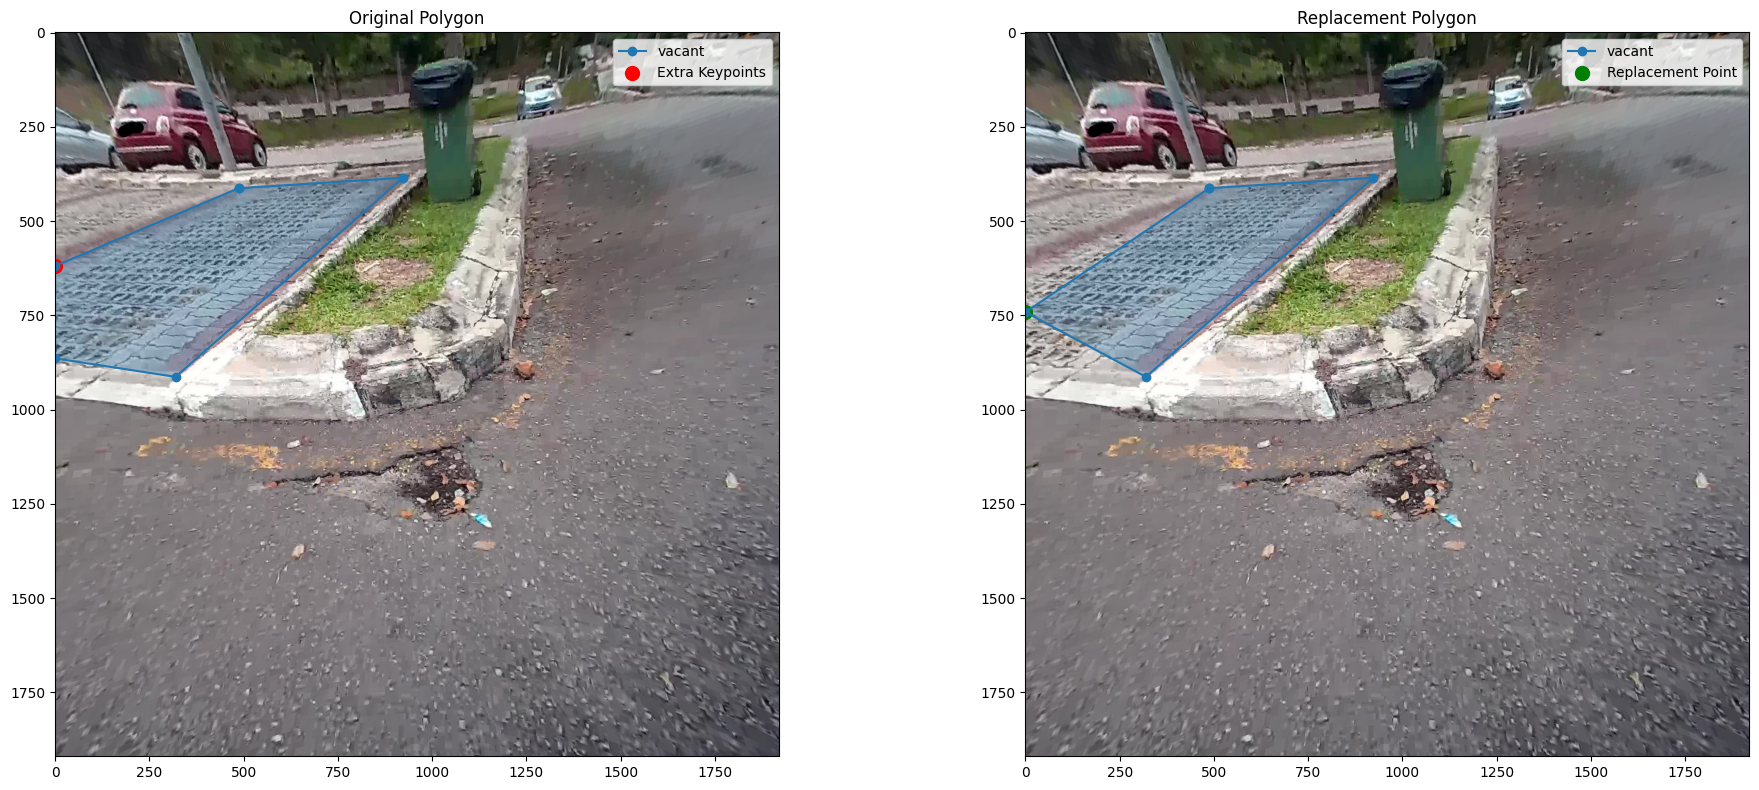

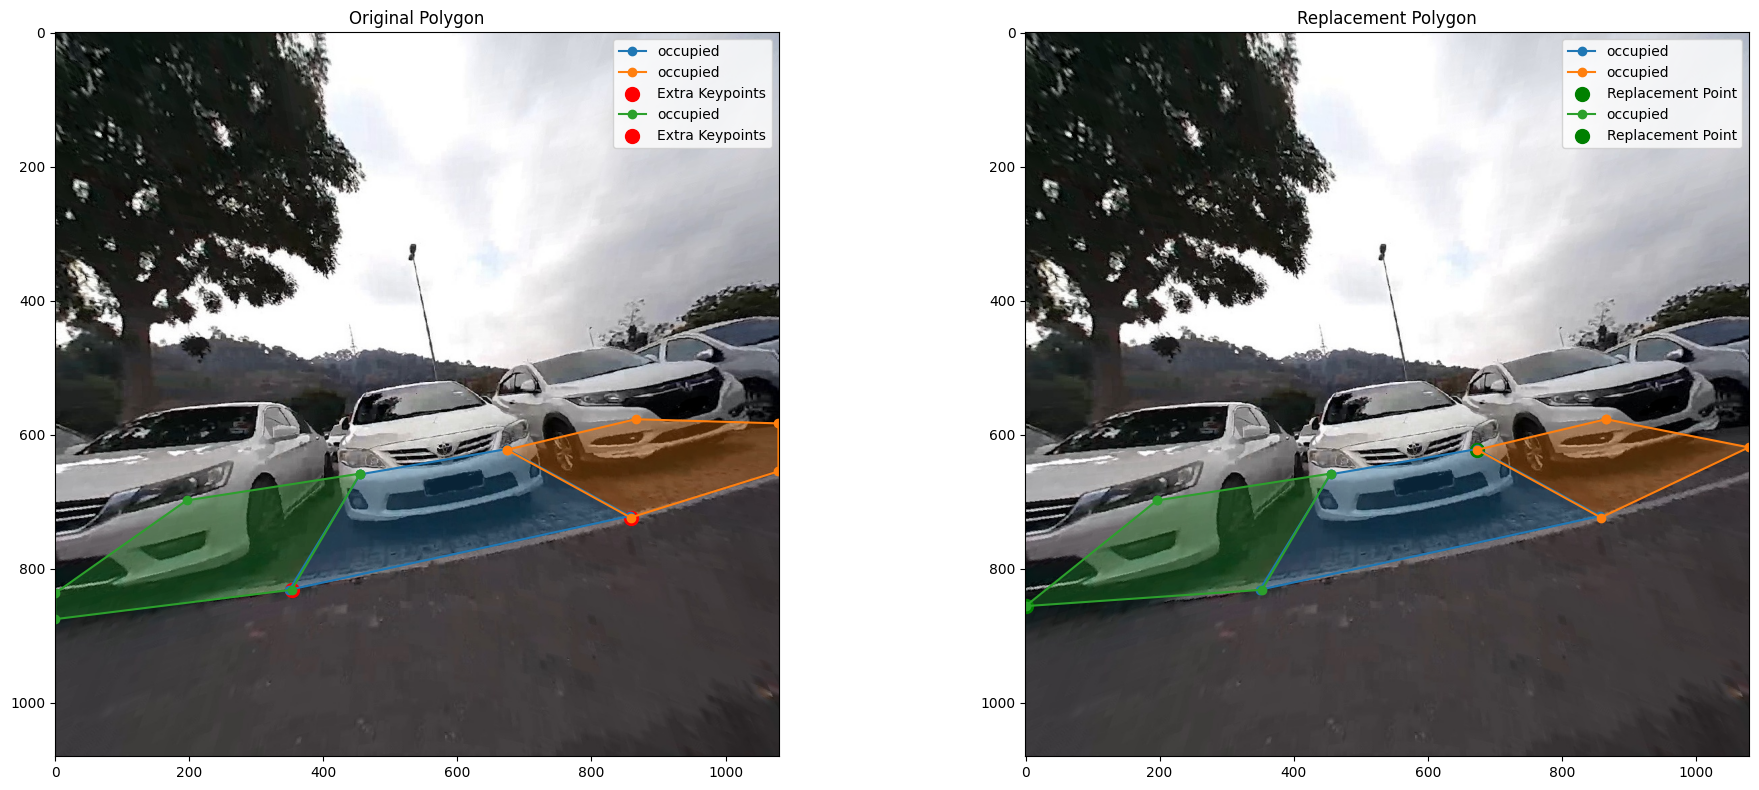

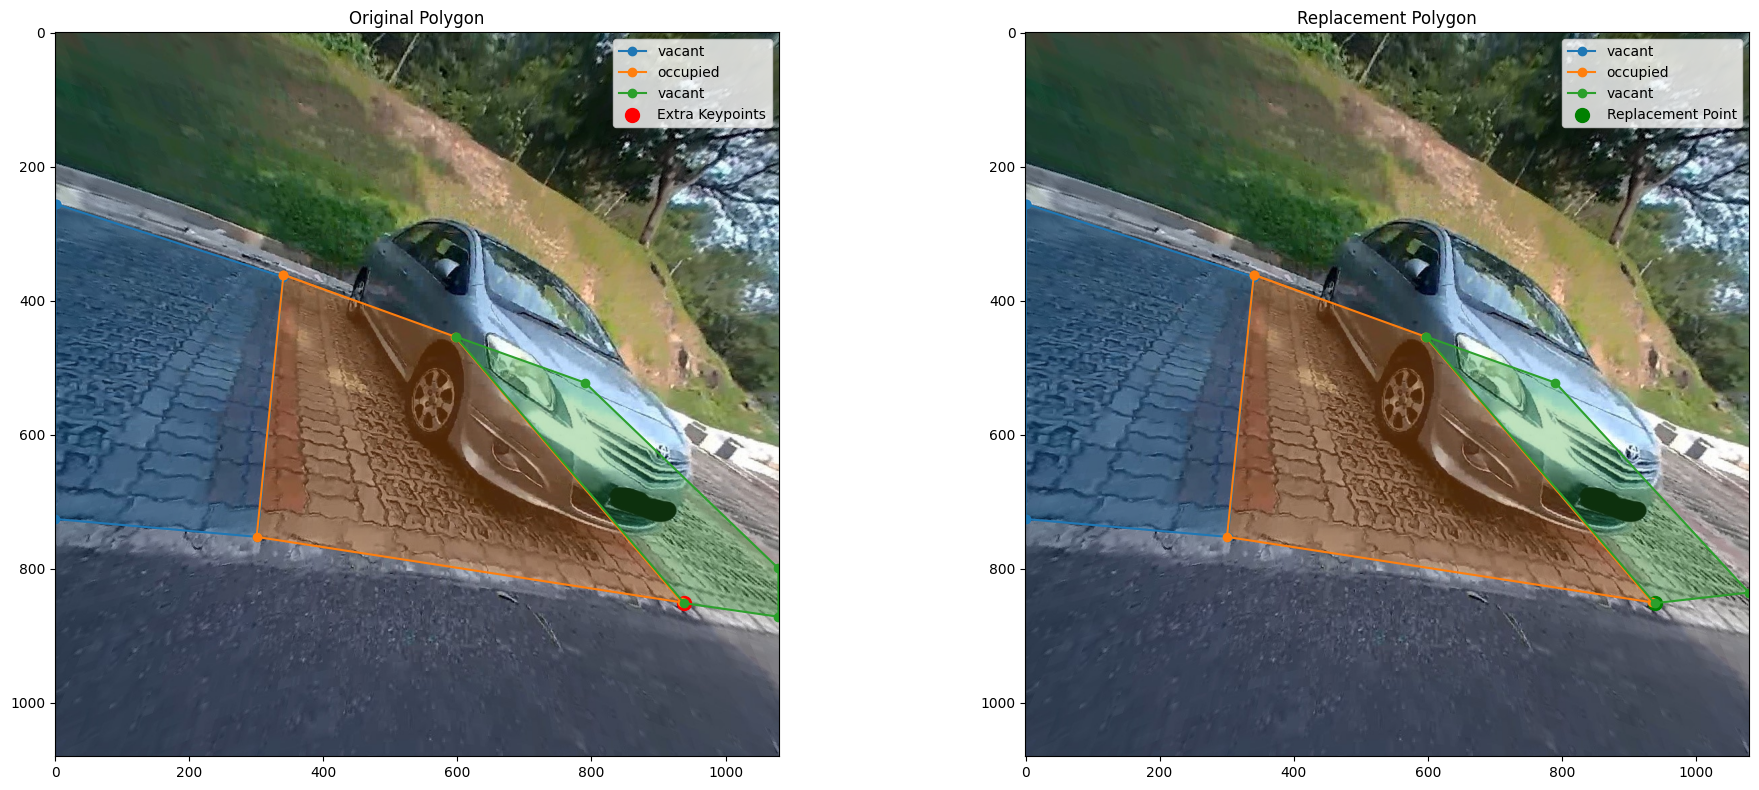

In [ ]:
# Directory containing JSON files
label_dir = '/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/labels'

# Filter images with 4+ keypoints
filtered_files = filter_images_with_4_plus_keypoints(label_dir)

# Visualize the first few examples
for filename in filtered_files[:20]:  # Adjust the number of examples as needed
    compare_original_and_replacement(filename)